# Implementación punto 3.1.3

Se calcula el ángulo de elevación de cada imagen.

In [1]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from statistics import mean
from IPython.display import Image  # Import the Image class
from Point_311 import pt311utils
from Point_311 import covMatrix
import pt313utils

In [2]:
def join_images(images):
    min_height = min([image.shape[0] for image in images])
    resized_imgs = [cv2.resize(image, (image.shape[1], min_height)) for image in images]
    joined_imgs = cv2.hconcat(resized_imgs)
    return joined_imgs

In [3]:
# def prev_post_values_b(current_b_index, b_list):
#     b_axes = []
#     # Calculate prev_b and post_b based on index
#     if current_b_index == 0:  # Grab last 3 items
#         b_axes = b_list[-3:]
#     elif  current_b_index == 1:
#         b_axes = [b_list[-1], *b_list[:current_b_index + 1]] # Grab last item and the first two
#     elif current_b_index == len(b_list) - 1:
#         b_axes = [*b_list[current_b_index - 2:], b_list[0]]  # Grab last two item and first one
#     else:
#         b_axes = b_list[current_b_index - 2 : current_b_index + 1]  # Grab prev item, current, last item
#     return b_axes

In [4]:
def estimate_b_axe_trend(b_axes):
    mean_seq = mean(b_axes)
    if b_axes[0] < mean_seq < b_axes[-1]:
        return True   # "Ascending"
    elif b_axes[0] > mean_seq > b_axes[-1]:
        return False  # "Descending"
    else:
        return None   # No clear trend

In [5]:
# def angle_estimation(A, B, b_i, b_axes):
#     fruit_rot = 'downwards'
#     cos_theta = math.sqrt((pow(b_i, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))
#     theta1 = np.arccos(cos_theta)
#     theta1 = np.degrees(theta1)
#     theta2 = -np.arccos(cos_theta)
#     theta2 = np.degrees(theta2)
#     ascending_sequence = None
#     b_axes_trend = estimate_b_axe_trend(b_axes)
#     rotation_per_view = 360 / len(b_axes)
#
#     if b_axes_trend > 0:
#         ascending_sequence = True
#     elif b_axes_trend < 0:
#         ascending_sequence = False
#
#     print("\n\t b_axes:  ", b_axes)
#
#     # if (b_axes[1] > b_axes[0]) and (fruit_rot == 'downwards') or (b_axes[0] > b_axes[1]) and (fruit_rot == 'upwards'):
#     if ascending_sequence is None:
#         theta = theta1
#     elif ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards'):
#         theta = theta1
#     else:
#         theta = theta2
#     return theta

In [6]:
def write_angle_on_img(img_to_draw, angle_text, color = (255, 0, 0)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    fontScale = 0.5
    thickness = 2

    cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
    return img_to_draw

# def write_angle_on_img(img_to_draw, angle_text, color = (255, 0, 0)):
#     font = cv2.FONT_HERSHEY_SIMPLEX
#     org = (50, 50)
#     fontScale = 1
#     thickness = 2
#
#     cv2.putText(img_to_draw, str(angle_text), org, font, fontScale, color, thickness, cv2.LINE_AA)
#     return img_to_draw

In [7]:
def calculate_oblate():
    a = mean(axe_a_all_views)
    b = min(axe_b_all_views)
    return [a, b]

In [8]:
# Declare vars for this angle estimation test
fruit_folder = "../data/tomatoes/obj0006"
axe_a_all_views = []
axe_b_all_views = []
oblate_spheroid = [] # A, B
prolate_spheroid = [] # A, B
ellipse_all_views = []
oblate_angles = []

# STORE LIST OF IMAGES WITH EDITED ANGLES
oblate_edited_imgs = []
prolate_edited_imgs = []
oblate_edited_axes_imgs = []


In [9]:
image_files = sorted([file for file in os.listdir(fruit_folder)])
for image_name in image_files:
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    mask = pt311utils.create_mask_from_img(img)
    ellipse = pt311utils.calculate_ellipse_from_mask(mask)
    center, axes_length, angle = ellipse
    minor_axis_length, major_axis_length = axes_length
    axe_b_all_views.append(minor_axis_length / 2)
    axe_a_all_views.append(major_axis_length / 2)
    ellipse_all_views.append(ellipse)


In [10]:
# Calculate oblate:
A = mean(axe_a_all_views)
B = min(axe_b_all_views)
oblate_spheroid = [A, B]

In [11]:
# # Calculate prolate:  FIXME: NOT FINISHED, JUST COPIED CODE ABOVE
# A = mean(axe_a_all_views)
# B = min(axe_b_all_views)
# prolate_spheroid = [A, B]

In [12]:
# TODO: TO CHECK SECOND AMBIGUITY

# def choose_smooth_angle(prev_angle, current_angle):
#     # Choose the angle closer to the previous angle
#     diff1 = abs(current_angle - prev_angle)
#     diff2 = abs(360 - diff1)
#
#     if diff1 < diff2:
#         return current_angle
#     else:
#         return 360 - current_angle

In [13]:
# print("ALL VIEWS B", axe_b_all_views)

# Angle estimation for each img

In [14]:
def prev_post_values_b(current_b_index, b_list, steps, direction = 0):
    enlarged_b_list = [*b_list, *b_list]
    enlarged_index = current_b_index + len(b_list) - 1 if current_b_index < (len(b_list) / 2) else current_b_index
    total_steps = 3 + steps

    if direction < 0:
        b_axes = enlarged_b_list[(enlarged_index - total_steps) : index]
    elif direction > 0:
        b_axes = enlarged_b_list[enlarged_index : (enlarged_index + total_steps)]
    else:
        b_axes = enlarged_b_list[enlarged_index - 2 : enlarged_index + 2]
    return b_axes

In [15]:
# def choose_smooth_angle(prev_angle):
#     prev_diff_90 = abs(prev_angle - 90)
#     prev_diff_0 = abs(prev_angle - 0)
#     prev_diff_minus_90 = abs(prev_angle + 90)
#     # Determine which reference angle has the minimum total difference
#     min_total_diff = min(prev_diff_90, prev_diff_0, prev_diff_minus_90)
#
#     if min_total_diff == prev_diff_90:
#         closest_angle = 90.0
#     elif min_total_diff == prev_diff_minus_90:
#         closest_angle = -90.0
#     else:
#         closest_angle = 0.0
#     return closest_angle

In [16]:
def choose_smooth_angle(calc_angle):
    angles = [0, 90, -90]
    closest = min(angles, key=lambda x: abs(calc_angle - x))
    return closest

In [17]:
def get_trend_for_view(index_view, direction = 0, step = 0):
    b_axes = prev_post_values_b(index_view, axe_b_all_views, step, direction)  # Try first with direction 0, in other recursions does direction 1 - forward
    trend = estimate_b_axe_trend(b_axes)
    if trend is None:
        return get_trend_for_view(index_view, 1, step + 1)
    else:
        return trend


In [18]:
# CALCULATE THE NEXT ANGLE IF NEEDED
def angle_estimation(index_view):
    if oblate_angles[index_view] != -1: return oblate_angles[index_view]   # Return if already calculated in another cycle

    #Spheroid values
    A, B = oblate_spheroid
    b_curr = axe_b_all_views[index_view]
    fruit_rot = 'downwards'
    curr_cos_theta = math.sqrt((pow(b_curr, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))

    curr_theta_pos = np.degrees(np.arccos(curr_cos_theta))
    curr_theta_neg = np.degrees(-np.arccos(curr_cos_theta))
    current_view_angles = (curr_theta_pos, curr_theta_neg)

    rotation_per_view = 360 / len(axe_b_all_views) + 5
    correct_theta = lambda ascending_sequence: current_view_angles[0] if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else current_view_angles[1]

    # Second ambiguity
    if 0 <= abs(current_view_angles[0]) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(current_view_angles[0]) >= 0:   # Value calculated is in range or a local extrema
        if index_view < len(image_files) - 1:
            temp_correct_theta_value = correct_theta(get_trend_for_view(index_view, 0))
            oblate_angles[index_view] = temp_correct_theta_value
            next_view_angle = angle_estimation(index_view + 1)
            print(oblate_angles[index_view - 1], next_view_angle)
            print("CONDITION: ", next_view_angle in [0.0, 90.0, -90.0], oblate_angles[index_view - 1] in [0.0, 90.0, -90.0])
            if next_view_angle in [0.0, 90.0, -90.0] or oblate_angles[index_view - 1] in [0.0, 90.0, -90.0]:
                theta = correct_theta(get_trend_for_view(index_view, 0))
                print(theta)
            else:
                theta = choose_smooth_angle(next_view_angle)                         # Choose the smoothest angle for the current value
        else:
            theta = correct_theta(get_trend_for_view(index_view, 0))                           # Find the right angle with the resulting trend from the values
    else:
        theta = correct_theta(get_trend_for_view(index_view, 0))                           # Find the right angle with the resulting trend from the values

    oblate_angles[index_view] = theta
    return theta

In [19]:
# def angle_estimation(index_view):
#     #Spheroid values
#     A, B = oblate_spheroid
#     b_i = axe_b_all_views[index_view]
#
#     fruit_rot = 'downwards'
#     cos_theta = math.sqrt((pow(b_i, 2) - pow(B, 2))/(pow(A, 2) - pow(B, 2)))
#     theta1 = np.arccos(cos_theta)
#     theta1 = np.degrees(theta1)
#     theta2 = -np.arccos(cos_theta)
#     theta2 = np.degrees(theta2)
#     is_oblate_angles_empty = len(oblate_angles) == 0
#
#     rotation_per_view = 360 / len(axe_b_all_views)
#     correct_theta = lambda ascending_sequence: theta1 if ascending_sequence and (fruit_rot == 'downwards') or (not ascending_sequence) and (fruit_rot == 'upwards') else theta2
#
#     # Second ambiguity
#     if 0 <= abs(theta1) <= rotation_per_view or abs(90 - rotation_per_view) <= abs(theta1) >= 0:   # Value calculated is in range or a local extrema
#         if not is_oblate_angles_empty:                                                             # There is a previous angle to compare
#             if oblate_angles[index - 1] in [0, 90, -90]:                                           # The prev angle is one of the local extremas
#                 theta = correct_theta(get_trend_for_view(index_view, 0))                           # Find the right angle with the resulting trend from the values
#                 # FIXME: What happens when theta result is a local extrema
#             else:
#                 theta = choose_smooth_angle(oblate_angles[index - 1])                              # Choose the smoothest angle based on the previous value
#         else:
#             theta = choose_smooth_angle(theta1)                                                    # If there is no prev angle to compare, choose the smoothest angle based on resulting theta1
#     else:
#         theta = correct_theta(get_trend_for_view(index_view, 0))                           # Find the right angle with the resulting trend from the values
#
#     return theta

In [20]:
oblate_angles = [-1 for element in range(len(image_files))]
for index, image_name in enumerate(image_files):
    # Read current image
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)
    img_axes = cv2.imread(file_path)

    # Estimate angle
    oblate_angle = angle_estimation(index) # A, B, b_i, b_axes[i-1, i, i+1]

    write_angle_on_img(img, oblate_angle, (0, 255, 0)) # (image, angle to write, color of the text)
    oblate_edited_imgs.append(img)
    oblate_edited_axes_imgs.append(img_axes)

    pt311utils.draw_semi_axes_of_ellipse(img_axes, ellipse_all_views[index])

57.03392490819435 44.64219313836229
CONDITION:  False False
28.789334694961067 -34.925839987716884
CONDITION:  False False
-59.00415970042854 44.128083887554595
CONDITION:  False False
24.65240201839734 -28.965332030994002
CONDITION:  False False
44.128083887554595 0
CONDITION:  True False
24.65240201839734
-76.00466293632896 70.26686026778546
CONDITION:  False False
-57.34359165173748 90
CONDITION:  True False
-76.00466293632896


In [21]:
# JOIN AND SHOW ALL VIEWS WITH ANGLES
joined_oblate_images = join_images(oblate_edited_imgs)
cv2.imwrite("oblate_angles.png", joined_oblate_images)

joined_oblate_axes_images = join_images(oblate_edited_axes_imgs)
cv2.imwrite("oblate_axes.png" , joined_oblate_axes_images)

True

### Imagen de angulos para esferoide oblate

In [22]:
print(axe_b_all_views)

[112.05119323730469, 104.66801452636719, 118.1865005493164, 125.41111755371094, 126.78788757324219, 122.8157730102539, 111.12080383300781, 104.41645812988281, 118.44132232666016, 126.95450592041016, 127.58502197265625, 125.34147644042969, 118.427001953125, 111.9034423828125, 104.68231964111328, 102.78741455078125, 106.44963073730469]


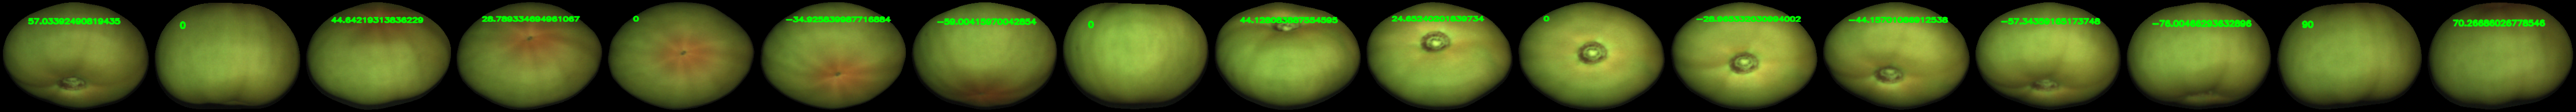

In [23]:
large_image_path = 'oblate_angles.png'
Image(filename=large_image_path, width=2000)

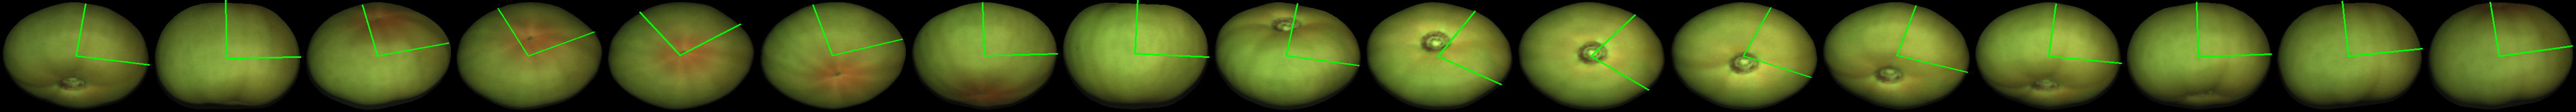

In [24]:
large_image_path = 'oblate_axes.png'
Image(filename=large_image_path, width=2000)

In [25]:
for index, image_name in enumerate(image_files):
    # Read current image
    file_path = os.path.join(fruit_folder, image_name)
    img = cv2.imread(file_path)

    # OBLATE

In [26]:
# random_list = [10, 20, 30, 40, 50, 60 , 70, 80, 90]
# b_axes = []
# last_index = len(random_list) - 1
# print("INDEX == 0", [*random_list[-3:], random_list[0]])
# print("INDEX == 1", [random_list[-1], *random_list[:1 + 1]])
# print("INDEX == LAST", [*random_list[last_index - 2:], random_list[0]])
# print("ALL ELSE", random_list[2 - 2 : 2 + 1])